# Prediction of Bikesharing in Washington DC

#### <<< Optimized using Dask >>>

One dataset contains hourly data and the other one has daily data from the years 2011 and 2012.

The following variables are included in the data:

* instant: Record index
* dteday: Date
* season: Season (1:springer, 2:summer, 3:fall, 4:winter)
* yr: Year (0: 2011, 1:2012)
* mnth: Month (1 to 12)
* hr: Hour (0 to 23, only available in the hourly dataset)
* holiday: whether day is holiday or not (extracted from Holiday Schedule)
* weekday: Day of the week
* workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit: (extracted from Freemeteo)
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
* atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered (Our target variable)

We are tasked with building a predictive model that can determine how many people will use the service on an hourly basis, therefore we take the first 5 quarters of the data for our training dataset and the last quarter of 2012 will be the holdout against which we perform our validation. Since that data was not used for training, we are sure that the evaluation metric that we get for it (R2 score) is an objective measurement of its predictive power.

Import the necessary libraries

In [101]:
import helpers as hp

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as metric_scorer
from sklearn.externals.joblib import parallel_backend
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

from dask import dataframe as dd
from distributed import Client, progress
from dask_ml.preprocessing import OneHotEncoder, RobustScaler
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

Do not display warnings

In [102]:
import warnings
warnings.filterwarnings('ignore')

### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed

In [103]:
SEED = 1
DATA_PATH = 'https://gist.githubusercontent.com/f-loguercio/f5c10c97fe9afe58f77cd102ca81719b/raw/99fb846b22abc8855de305c2159a57a77c9764cf/bikesharing_hourly.csv'
DATA_PATH2 = 'https://gist.githubusercontent.com/f-loguercio/14ac934fabcca41093a51efef335f8f2/raw/58e00b425c711ac1da2fb75f851f4fc9ce814cfa/bikesharing_daily.csv'
PREC_PATH = 'https://gist.githubusercontent.com/f-loguercio/3d7be83a316ab9dce9b7bc0729940e42/raw/39a98fea3ad1d65b587a63f293e1c466f4180e4a/precipitation.csv'
TARGET_VARIABLE = 'cnt'
ESTIMATORS = 50

### Set up Dask

Get the access link to the dashboard in order to be able to track the progress and task distribution

In [104]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:52531 Dashboard: http://127.0.0.1:52532/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


### Data Loading & Preparation

In [105]:
def read_data(input_path):
    return dd.read_csv(input_path)

data = read_data(DATA_PATH)
data_daily = read_data(DATA_PATH2)

In [106]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Additional Data - Precipitation

In order to generate my model, I will add precipitation data obtained from the National Climatic Data Center https://www.ncdc.noaa.gov/cdo-web/datasets

However, since most of the values are 0, I will convert them to a boolean that determines if rain was present or not at that specific hour

In [107]:
precipitation = read_data(PREC_PATH)
data = data.merge(precipitation, how='left', on=['dteday','hr'])
data['precipitation'] = data['precipitation'].fillna(0)

In [108]:
data['precipitation'] = data['precipitation'].map(lambda x: x > 0)
data['precipitation'] = data['precipitation'].astype(int).astype('category')

In [109]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,precipitation
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1


Coerce date to datetime

In [110]:
data['dteday'] = dd.to_datetime(data.dteday, format='%Y/%m/%d')

### Data types

I review the data types for each column

In [111]:
data.dtypes

instant                   int64
dteday           datetime64[ns]
season                    int64
yr                        int64
mnth                      int64
hr                        int64
holiday                   int64
weekday                   int64
workingday                int64
weathersit                int64
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
cnt                       int64
precipitation          category
dtype: object

### Converting columns to their true categorical type
Now I convert the data types of numerical columns that are actually categorical

In [112]:
data = hp.convert_to_category(data, ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit'])

data = data.categorize() #needed for the column transformers later
data.dtypes

instant                   int64
dteday           datetime64[ns]
season                 category
yr                     category
mnth                   category
hr                     category
holiday                category
weekday                category
workingday             category
weathersit             category
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
cnt                       int64
precipitation          category
dtype: object

### Adding lag of registered users

In order to improve the long term prediction efficacy of our model I will take an autoregressive forecasting approach and add lags of the number of users for the previous hour and the previous 24 hours

In [113]:
def add_lag(df, col, lag):
    lagged = df[col].shift(lag).rename(str(col) + '_' + str(lag))
    return lagged

data = dd.concat([data, add_lag(data, 'registered', 1), add_lag(data, 'registered', 24)], axis = 1)

# Drop the rows that have nan due to lag. They are very few and therefore neglectable.
data = data.dropna(how = 'any')

data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,precipitation,registered_1,registered_24
24,25,2011-01-02,1,0,1,0,0,0,0,2,0.46,0.4545,0.88,0.2985,4,13,17,1,24.0,13.0
25,26,2011-01-02,1,0,1,1,0,0,0,2,0.44,0.4394,0.94,0.2537,1,16,17,1,13.0,32.0
26,27,2011-01-02,1,0,1,2,0,0,0,2,0.42,0.4242,1.00,0.2836,1,8,9,1,16.0,27.0
27,28,2011-01-02,1,0,1,3,0,0,0,2,0.46,0.4545,0.94,0.1940,2,4,6,1,8.0,10.0
28,29,2011-01-02,1,0,1,4,0,0,0,2,0.46,0.4545,0.94,0.1940,2,1,3,1,4.0,1.0


### Dropping Columns

Dropping casual and registered columns

In [114]:
data = hp.drop_columns(data, ['casual', 'registered'])
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,precipitation,registered_1,registered_24
24,25,2011-01-02,1,0,1,0,0,0,0,2,0.46,0.4545,0.88,0.2985,17,1,24.0,13.0
25,26,2011-01-02,1,0,1,1,0,0,0,2,0.44,0.4394,0.94,0.2537,17,1,13.0,32.0
26,27,2011-01-02,1,0,1,2,0,0,0,2,0.42,0.4242,1.00,0.2836,9,1,16.0,27.0
27,28,2011-01-02,1,0,1,3,0,0,0,2,0.46,0.4545,0.94,0.1940,6,1,8.0,10.0
28,29,2011-01-02,1,0,1,4,0,0,0,2,0.46,0.4545,0.94,0.1940,3,1,4.0,1.0


## Baseline

A basic linear model is created in order to set a baseline which further models will be compared against

In [115]:
base_holdout = data[data['dteday'] >= '2012-10-01'].copy()
holdout_final_plots = base_holdout.copy() # will need this for plots at the end
base_holdout = hp.drop_columns(base_holdout, ['dteday'])
base_data = data[data['dteday'] < '2012-10-01'].copy()
base_data = hp.drop_columns(base_data, ['dteday'])

X_train = base_data.loc[:, base_data.columns != TARGET_VARIABLE]
X_train.drop(['registered_1', 'registered_24'], axis = 1) # The lagged variables are excluded from the baseline
y_train = base_data.loc[:, TARGET_VARIABLE]

Use dask to fit the baseline model

In [116]:
model = LinearRegression()

with parallel_backend('dask'):
    model.fit(X_train, y_train)
    pred = model.predict(base_holdout.loc[:, base_holdout.columns != TARGET_VARIABLE])
    
y = base_holdout.loc[:, TARGET_VARIABLE]
score = metric_scorer(y, pred)
print('Baseline score: ' + str(score))

Baseline score: 0.7636766048033885


### Further Data Preparation & Feature Engineering

#### Lagged Variables

This section was moved above for convenience. The variables have been excluded until now.

#### Drop highly correlated columns

'workingday' is exactly the opposite of 'weekday', and 'atemp' is almost the same as 'temp'.

In [117]:
data = hp.drop_columns(data, ['workingday', 'atemp'])

### Choose Estimator & Preprocessing Configurations

Specify several configurations in form of pipelines to be compared

In [118]:
RF = RandomForestRegressor(n_estimators = ESTIMATORS, random_state = SEED)
GBT = GradientBoostingRegressor(n_estimators = ESTIMATORS, random_state = SEED)
ADA = AdaBoostRegressor(random_state = SEED)

categoricals = ['season', 'yr', 'mnth', 'weathersit']
numericals = ['temp', 'hum', 'windspeed', 'registered_1', 'registered_24']

ColumnTrans = ColumnTransformer([('onehot', OneHotEncoder(), categoricals),
                               ('robustscale', RobustScaler(), numericals)])

In [119]:
configs = {
    # Plain models (no preprocessing)
    'plainRF': RF,
    'plainGBT': GBT,
    'plainAda': ADA,
    
    # Repetition with preprocessing
    'preproc_RF': make_pipeline(ColumnTrans, RF),
    'preproc_GBT': make_pipeline(ColumnTrans, GBT),
    'preproc_Ada': make_pipeline(ColumnTrans, ADA),
}

In [120]:
grid_holdout = data[data['dteday'] >= '2012-10-01'].copy()
grid_holdout = hp.drop_columns(grid_holdout, ['dteday'])
grid_data = data[data['dteday'] < '2012-10-01'].copy()
grid_data = hp.drop_columns(grid_data, ['dteday'])

X_train_grid = grid_data.loc[:, grid_data.columns != TARGET_VARIABLE]
y_train_grid = grid_data.loc[:, TARGET_VARIABLE]

Make a time-series train-test split of the training data and select model performing best on the last section of the training data

In [121]:
categoricals = ['season', 'yr', 'mnth', 'weathersit']
numericals = ['temp', 'hum', 'windspeed', 'registered_1', 'registered_24']

In [122]:
train_size = int(len(X_train_grid) * 0.85)
data_scoring, data_validate = grid_data[0:train_size], grid_data[train_size:len(grid_data)]
X_scoring, X_validate, y_scoring, y_validate = data_scoring.loc[:, data_scoring.columns != TARGET_VARIABLE], data_validate.loc[:, data_validate.columns != TARGET_VARIABLE], data_scoring.loc[:, TARGET_VARIABLE], data_validate.loc[:, TARGET_VARIABLE]

scores = []

for name, config in configs.items():
    with parallel_backend('dask'):
        config.fit(X_scoring, y_scoring)
        pred = config.predict(X_validate)
    scores.append([name, metric_scorer(y_validate, pred)])

print(*scores, sep = "\n")

['plainRF', 0.9230281224467282]
['plainGBT', 0.8658336934633153]
['plainAda', 0.8012954882646525]
['preproc_RF', 0.8135899010150364]
['preproc_GBT', 0.8049790452506292]
['preproc_Ada', 0.7517800839896766]


The plain random forest clearly outperforms the other configurations. I will therefore proceed with the random forest.

### Perform Dask Gridsearch to determine the best combination of hyperparameters

In [123]:
grid = {
    'criterion': ['mse'],
    'max_depth': [5, 10, 30],
    'min_samples_leaf': [2, 4, 10],
    'min_samples_split': [5, 10],
    'max_leaf_nodes': [20, 50, 100],
}

In [124]:
GridSearch = DaskGridSearchCV(estimator = RF, param_grid = grid)
GridSearch.fit(X_train_grid, y_train_grid)

GridSearch.best_params_

{'criterion': 'mse',
 'max_depth': 10,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 10,
 'min_samples_split': 5}

### Final score on holdout months

In [125]:
y_pred = GridSearch.predict(grid_holdout.loc[:, grid_data.columns != TARGET_VARIABLE])

y = grid_holdout.loc[:, TARGET_VARIABLE]
score = metric_scorer(y, y_pred)
score

0.9068143419563879

### Three week prediction vs. reality plot

Pandas structures are used for the plotting

Text(0, 0.5, 'Users')

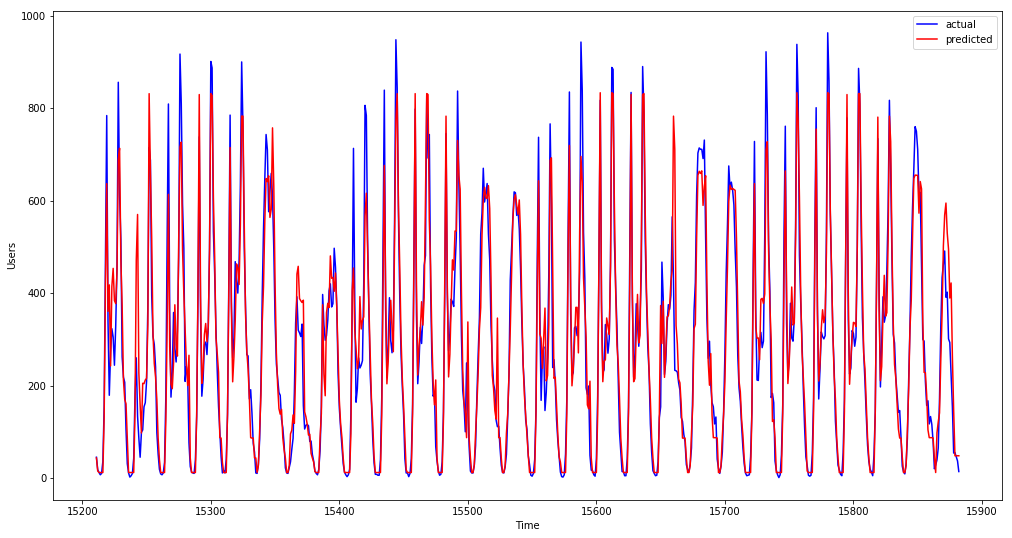

In [126]:
y_plotting = y.compute()
y_pred_plotting = pd.Series(y_pred, index = y_plotting.index)

plt.figure(figsize=(17, 9))
ax = sns.lineplot(data = y_plotting[0:672], color='blue', label = 'actual')
ax = sns.lineplot(data = y_pred_plotting[0:672], color='red', label = 'predicted')

plt.xlabel('Time')
plt.ylabel('Users')

### Entire prediction vs. reality plot

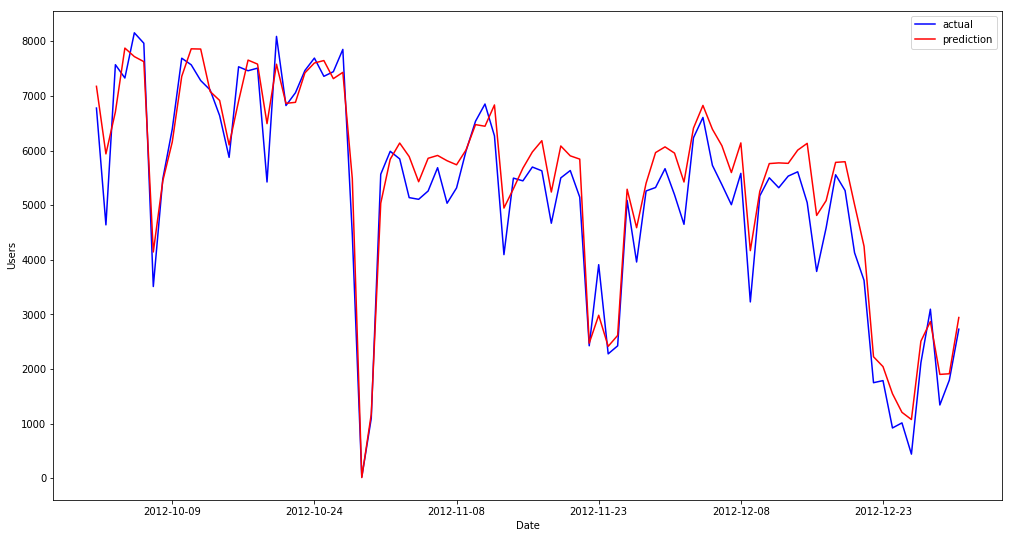

In [127]:
df_holdout_final_plots = holdout_final_plots.compute()
df_holdout_final_plots['pred'] = y_pred_plotting

holdout_daily = pd.DataFrame(df_holdout_final_plots.groupby(["dteday"])[["pred", 'cnt']].sum()).reset_index()
ax = plt.figure(figsize=(17, 9))
ax = sns.lineplot(data = holdout_daily, x = 'dteday', y = 'cnt', color='blue', label = 'actual')
ax = sns.lineplot(data = holdout_daily, x = 'dteday', y = 'pred', color='red', label = 'prediction')
plt.xlabel('Date')
plt.ylabel('Users')
ax.xaxis.set_major_locator(plt.MaxNLocator(8))